<a href="https://colab.research.google.com/github/dbrims/API_homework/blob/master/project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for Machine learning models



```
# This is formatted as code
```

# Data aggregation and cleaning

In [ ]:
import csv
!pip install altair
!pip install plotly-express
!pip install python-dotenv
import altair as alt
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import plotly.express as px
from sklearn.metrics import r2_score
import requests
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
import requests
import json
from urllib.request import urlopen
from dotenv import load_dotenv
load_dotenv()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



True

In [ ]:
'''Reading in the house market dataset from Redfin.  The data set was too big for Github so you will need to download it 
from https://www.redfin.com/blog/data-center/ also the simplemap data can be downloaded from https://simplemaps.com/data/us-cities.'''
file=Path('./weekly_housing_market_data_most_recent.tsv')
df = pd.read_csv(file,sep='\t')
df.shape

(984117, 76)

In [ ]:
features=df.columns.tolist()
features

['region_id',
 'region_type_id',
 'region_name',
 'region_type',
 'period_begin',
 'period_end',
 'duration',
 'total_homes_sold',
 'total_homes_sold_yoy',
 'average_homes_sold',
 'average_homes_sold_yoy',
 'total_homes_sold_with_price_drops',
 'total_homes_sold_with_price_drops_yoy',
 'average_homes_sold_with_price_drops',
 'average_homes_sold_with_price_drops_yoy',
 'percent_homes_sold_with_price_drops',
 'percent_homes_sold_with_price_drops_yoy',
 'median_sale_price',
 'median_sale_price_yoy',
 'median_sale_ppsf',
 'median_sale_ppsf_yoy',
 'median_days_to_close',
 'median_days_to_close_yoy',
 'price_drops',
 'price_drops_yoy',
 'percent_active_listings_with_price_drops',
 'percent_active_listings_with_price_drops_yoy',
 'pending_sales',
 'pending_sales_yoy',
 'median_pending_sqft',
 'median_pending_sqft_yoy',
 'off_market_in_two_weeks',
 'off_market_in_two_weeks_yoy',
 'percent_off_market_in_two_weeks',
 'percent_off_market_in_two_weeks_yoy',
 'total_new_listings',
 'total_new_listi

In [ ]:
'''We are choosing 6 geographies from our datasel, and choosing the data from the most recent 4 weeks.  These data are then 
assembled in a new datafrom.  Various columns are being dropped they have the most NA, and since these features are not vital, their removal
maximizes the number of towns remaining in the data set when all NAs are dropped'''

states=['NY','TX','IL', 'CA', 'FL', 'WA']
df2=df.loc[(df['period_end']=='2020-08-09')&(df['period_begin']=='2020-07-13')].copy()
df2.shape


(1742, 76)

In [ ]:
s=0
for state in states:
    if s==0:
        s+=1
        df_state=df2[df2['region_name'].str.contains(f"{state} metro area")].copy()
        for ind in range(len(df_state.index)):
            df_state.iloc[ind,2]= df_state.iloc[ind,2][0:-11]
        df_state.set_index('region_name', inplace=True)
        df_state.drop(columns=['region_id',
                               'region_type_id', 
                               'region_type', 
                               'period_begin', 
                               'period_end', 
                               'duration',
                               'last_updated',
                               'avg_offer_to_list', 
                               'average_of_median_list_price_amount', 
                               'average_of_median_offer_price_amount', 
                               'avg_offer_to_list_yoy', 
                               'average_of_median_list_price_amount_yoy', 
                               'average_of_median_offer_price_amount_yoy'], 
                      inplace=True)
        
    else:
        data=df2[df2['region_name'].str.contains(f"{state} metro area")].copy()
        for ind in range(len(data.index)):
            data.iloc[ind,2]= data.iloc[ind,2][0:-11]
        data.set_index('region_name', inplace=True)
        data.drop(columns=['region_id',
                               'region_type_id', 
                               'region_type', 
                               'period_begin', 
                               'period_end', 
                               'duration',
                               'last_updated',
                               'avg_offer_to_list', 
                               'average_of_median_list_price_amount', 
                               'average_of_median_offer_price_amount', 
                               'avg_offer_to_list_yoy', 
                               'average_of_median_list_price_amount_yoy', 
                               'average_of_median_offer_price_amount_yoy'], 
                      inplace=True)
        df_state=pd.concat([df_state, data], axis=0, join='inner')
    # df_state=df_state.dropna()
df_state.head()

,total_homes_sold,total_homes_sold_yoy,average_homes_sold,average_homes_sold_yoy,total_homes_sold_with_price_drops,total_homes_sold_with_price_drops_yoy,average_homes_sold_with_price_drops,average_homes_sold_with_price_drops_yoy,percent_homes_sold_with_price_drops,percent_homes_sold_with_price_drops_yoy,median_sale_price,median_sale_price_yoy,median_sale_ppsf,median_sale_ppsf_yoy,median_days_to_close,median_days_to_close_yoy,price_drops,price_drops_yoy,percent_active_listings_with_price_drops,percent_active_listings_with_price_drops_yoy,pending_sales,pending_sales_yoy,median_pending_sqft,median_pending_sqft_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,percent_off_market_in_two_weeks,percent_off_market_in_two_weeks_yoy,total_new_listings,total_new_listings_yoy,average_new_listings,average_new_listings_yoy,median_new_listing_price,median_new_listing_price_yoy,median_new_listing_ppsf,median_new_listing_ppsf_yoy,inventory,inventory_yoy,total_active_listings,total_active_listings_yoy,active_listings,active_listings_yoy,age_of_inventory,age_of_inventory_yoy,homes_delisted,homes_delisted_yoy,percent_active_listings_delisted,percent_active_listings_delisted_yoy,median_active_list_price,median_active_list_price_yoy,median_active_list_ppsf,median_active_list_ppsf_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_days_on_market,median_days_on_market_yoy,pending_sales_to_sales_ratio,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy
region_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Jamestown, NY",84.0,-0.142857,21.0,-0.125000,23.0,-0.080000,5.0,-0.166667,0.275260,0.023458,116737.5,0.149642,72.566547,0.044978,54.3,-2.4,14.0,-0.333333,0.049308,0.009563,20.0,-0.047619,1661.7,0.111356,11.0,0.571429,0.560208,0.215848,131.0,-0.090278,32.0,-0.111111,142525.0,0.139630,86.381943,0.139314,263.0,-0.483301,1179.0,-0.455427,294.0,-0.456562,49.5,-16.8,6.0,0.500000,0.020303,0.012442,134675.0,0.127813,82.383557,0.081700,0.952246,0.001782,98.0,42.8,1.015183,0.146447,14.173419,-8.227478,59.0,0.512821
"New York, NY",3637.0,-0.319424,909.0,-0.319611,899.0,-0.444032,224.0,-0.445545,0.247577,-0.055692,533312.5,0.009822,294.300275,-0.010677,47.0,-4.5,1557.0,0.159345,0.041836,0.005533,704.0,-0.049933,1675.0,0.068444,104.0,0.444444,0.145899,0.048232,10367.0,0.597381,2591.0,0.597411,660749.7,0.171282,381.620062,0.183956,35505.0,0.016607,148983.0,0.007275,37245.0,0.007275,61.5,-25.0,710.0,0.015737,0.019025,0.000113,701607.2,0.034437,406.180396,0.130664,0.981628,0.005113,73.2,4.7,0.782276,0.223229,41.317834,13.176189,1688.0,0.324961
"Gloversville, NY",53.0,0.472222,13.0,0.444444,21.0,0.500000,5.0,0.666667,0.380987,-0.024496,97583.0,-0.237633,77.974513,-0.250516,41.5,-14.0,12.0,-0.333333,0.066059,0.005421,11.0,0.375000,1565.1,0.005202,5.0,1.500000,0.511364,0.136364,77.0,0.241935,19.0,0.266667,167437.5,0.035482,107.924186,0.100811,171.0,-0.412371,755.0,-0.382666,188.0,-0.383607,54.2,-23.8,3.0,0.000000,0.019886,0.010133,156512.5,0.096698,92.411027,0.104857,0.938598,-0.026252,102.0,70.0,0.836765,-0.186684,14.751681,-20.134683,16.0,0.000000
"Syracuse, NY",473.0,-0.304412,118.0,-0.305882,84.0,-0.511628,21.0,-0.511628,0.180900,-0.071130,164512.5,0.111853,106.553222,0.090416,51.2,3.4,61.0,-0.460177,0.050443,0.000889,118.0,-0.132353,1640.1,0.012282,85.0,1.361111,0.724675,0.455254,770.0,-0.083333,192.0,-0.085714,170712.5,0.146298,108.861177,0.146201,1077.0,-0.490298,4883.0,-0.468141,1220.0,-0.468410,42.2,-7.3,15.0,-0.250000,0.012458,0.003655,177425.0,0.109600,105.713202,0.108403,1.002117,0.020436,26.3,-6.0,1.018147,0.210087,10.740565,-2.941033,306.0,0.020000
"Batavia, NY",30.0,-0.347826,7.0,-0.363636,4.0,-0.500000,1.0,-0.500000,0.159722,-0.021413,181100.0,0.499855,105.729990,0.332969,58.1,-8.7,4.0,-0.428571,0.058861,-0.005753,11.0,0.571429,1526.3,-0.052341,7.0,1.333333,0.664216,0.188025,60.0,-0.117647,15.0,-0.117647,144062.

In [ ]:
''' this code will use data from SimpleMaps and pull the county, populatio and density for each city
 and the LON/LAT data'''

df_state['county']=np.nan
df_state['Lat']=np.nan
df_state['Lon']=np.nan
df_state['pop']=np.nan
df_state['density']=np.nan

file=Path('./uscities.csv')
cf=pd.read_csv(file)

for ind, row in df_state.iterrows():
    state=ind[-2:]
    town=ind[0:-4]
    x=cf.loc[(cf['state_id']==state)&(cf['city']==town)]
    try:
        y=x.index[0]
        df_state.loc[ind, 'county']=cf.loc[y,'county_name']
        df_state.loc[ind, 'Lat']=cf.loc[y,'lat']
        df_state.loc[ind, 'Lon']=cf.loc[y,'lng']
        df_state.loc[ind, 'density']=cf.loc[y,'density']
        df_state.loc[ind, 'pop']=cf.loc[y,'population']
    except:
        continue
df_state.head()

,total_homes_sold,total_homes_sold_yoy,average_homes_sold,average_homes_sold_yoy,total_homes_sold_with_price_drops,total_homes_sold_with_price_drops_yoy,average_homes_sold_with_price_drops,average_homes_sold_with_price_drops_yoy,percent_homes_sold_with_price_drops,percent_homes_sold_with_price_drops_yoy,median_sale_price,median_sale_price_yoy,median_sale_ppsf,median_sale_ppsf_yoy,median_days_to_close,median_days_to_close_yoy,price_drops,price_drops_yoy,percent_active_listings_with_price_drops,percent_active_listings_with_price_drops_yoy,pending_sales,pending_sales_yoy,median_pending_sqft,median_pending_sqft_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,percent_off_market_in_two_weeks,percent_off_market_in_two_weeks_yoy,total_new_listings,total_new_listings_yoy,average_new_listings,average_new_listings_yoy,median_new_listing_price,median_new_listing_price_yoy,median_new_listing_ppsf,median_new_listing_ppsf_yoy,inventory,inventory_yoy,total_active_listings,total_active_listings_yoy,active_listings,active_listings_yoy,age_of_inventory,age_of_inventory_yoy,homes_delisted,homes_delisted_yoy,percent_active_listings_delisted,percent_active_listings_delisted_yoy,median_active_list_price,median_active_list_price_yoy,median_active_list_ppsf,median_active_list_ppsf_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_days_on_market,median_days_on_market_yoy,pending_sales_to_sales_ratio,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,county,Lat,Lon,pop,density
region_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Jamestown, NY",84.0,-0.142857,21.0,-0.125000,23.0,-0.080000,5.0,-0.166667,0.275260,0.023458,116737.5,0.149642,72.566547,0.044978,54.3,-2.4,14.0,-0.333333,0.049308,0.009563,20.0,-0.047619,1661.7,0.111356,11.0,0.571429,0.560208,0.215848,131.0,-0.090278,32.0,-0.111111,142525.0,0.139630,86.381943,0.139314,263.0,-0.483301,1179.0,-0.455427,294.0,-0.456562,49.5,-16.8,6.0,0.500000,0.020303,0.012442,134675.0,0.127813,82.383557,0.081700,0.952246,0.001782,98.0,42.8,1.015183,0.146447,14.173419,-8.227478,59.0,0.512821,Chautauqua,42.0975,-79.2366,41236.0,1278.0
"New York, NY",3637.0,-0.319424,909.0,-0.319611,899.0,-0.444032,224.0,-0.445545,0.247577,-0.055692,533312.5,0.009822,294.300275,-0.010677,47.0,-4.5,1557.0,0.159345,0.041836,0.005533,704.0,-0.049933,1675.0,0.068444,104.0,0.444444,0.145899,0.048232,10367.0,0.597381,2591.0,0.597411,660749.7,0.171282,381.620062,0.183956,35505.0,0.016607,148983.0,0.007275,37245.0,0.007275,61.5,-25.0,710.0,0.015737,0.019025,0.000113,701607.2,0.034437,406.180396,0.130664,0.981628,0.005113,73.2,4.7,0.782276,0.223229,41.317834,13.176189,1688.0,0.324961,New York,40.6943,-73.9249,19354922.0,11083.0
"Gloversville, NY",53.0,0.472222,13.0,0.444444,21.0,0.500000,5.0,0.666667,0.380987,-0.024496,97583.0,-0.237633,77.974513,-0.250516,41.5,-14.0,12.0,-0.333333,0.066059,0.005421,11.0,0.375000,1565.1,0.005202,5.0,1.500000,0.511364,0.136364,77.0,0.241935,19.0,0.266667,167437.5,0.035482,107.924186,0.100811,171.0,-0.412371,755.0,-0.382666,188.0,-0.383607,54.2,-23.8,3.0,0.000000,0.019886,0.010133,156512.5,0.096698,92.411027,0.104857,0.938598,-0.026252,102.0,70.0,0.836765,-0.186684,14.751681,-20.134683,16.0,0.000000,Fulton,43.0491,-74.3465,27893.0,1143.0
"Syracuse, NY",473.0,-0.304412,118.0,-0.305882,84.0,-0.511628,21.0,-0.511628,0.180900,-0.071130,164512.5,0.111853,106.553222,0.090416,51.2,3.4,61.0,-0.460177,0.050443,0.000889,118.0,-0.132353,1640.1,0.012282,85.0,1.361111,0.724675,0.455254,770.0,-0.083333,192.0,-0.085714,170712.5,0.146298,108.861177,0.146201,1077.0,-0.490298,4883.0,-0.468141,1220.0,-0.468410,42.2,-7.3,15.0,-0.250000,0.012458,0.003655,177425.0,0.109600,105.713202,0.108403,1.002117,0.020436,26.3,-6.0,1.018147,0.210087,10.740565,-2.941033,306.0,0.020000,Onondaga,43.0409,-76.1438,407259.0,2212.0
"Batavia, NY",30.0,-0.347826,7.0,-0.363636,4.0,-0.500000,1.0,-0.50000

In [ ]:
df_state=df_state.dropna()
df_state.shape

(96, 67)

In [ ]:
'''two new datasets are created from the pooled municipality data, one dataset containing all the features will be used
for a clustering analysis, the second data set will be the feature and target set used in the supervised neural network.
The target we chose was average price per square foot in each municipality'''

cluster=df_state.drop(columns=['county'])
cluster_scaled= (cluster - cluster.min()) / (cluster.max() - cluster.min())
y=df_state['median_sale_ppsf']
X_scaled=cluster_scaled.drop(columns=['median_sale_ppsf'])

cluster_train, cluster_test= train_test_split(cluster_scaled, test_size=0.50,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,  test_size=0.66,random_state=42)
X_train.shape

(32, 65)

In [ ]:
X_test.shape

(64, 65)

# Neural network models

In [ ]:
'''Testing 3 models, each with a different number of hidden layers, 1, 2, or 3.  We are using a bog standard neural net, since 
without time series data, an LTMN model is not required'''
number_input_features = X_scaled.shape[1]
hidden_nodes_layer1 = number_input_features*3
hidden_nodes_layer2 = number_input_features*3
hidden_nodes_layer3 = number_input_features*3

nn1 = Sequential()
# First hidden layer
nn1.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn1.add(Dense(units=hidden_nodes_layer2, activation="relu"))
# Second hidden layer
nn1.add(Dense(units=hidden_nodes_layer3, activation="relu"))
# Output layer
nn1.add(Dense(units=1, activation="linear"))
# Compile model
nn1.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_1 = nn1.fit(X_train, y_train, validation_split=0.3, epochs=200, verbose=0)

In [ ]:
number_input_features = X_scaled.shape[1]
hidden_nodes_layer1 = number_input_features*3
hidden_nodes_layer2 = number_input_features*3


nn2 = Sequential()
# First hidden layer
nn2.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn2.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn2.add(Dense(units=1, activation="linear"))
# Compile model
nn2.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_2 = nn2.fit(X_train, y_train, validation_split=0.3, epochs=200, verbose=0)

In [ ]:

number_input_features = X_scaled.shape[1]
hidden_nodes_layer1 = number_input_features*3



nn3 = Sequential()
# First hidden layer
nn3.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Output layer
nn3.add(Dense(units=1, activation="linear"))
# Compile model
nn3.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_3 = nn3.fit(X_train, y_train, validation_split=0.3, epochs=200, verbose=0)

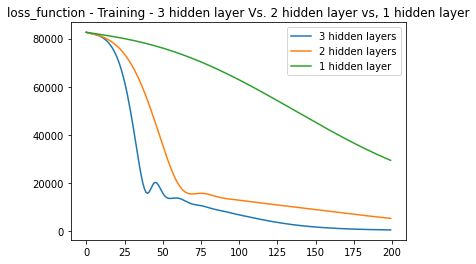

In [ ]:
'''The loss funtions are compared for each model, and the amount of overfitting is also evaluated'''

# Plot the loss function of the training results for the two models
plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.plot(model_3.history["loss"])
plt.title("loss_function - Training - 3 hidden layer Vs. 2 hidden layer vs, 1 hidden layer")
plt.legend(["3 hidden layers", "2 hidden layers","1 hidden layer" ])
plt.show()

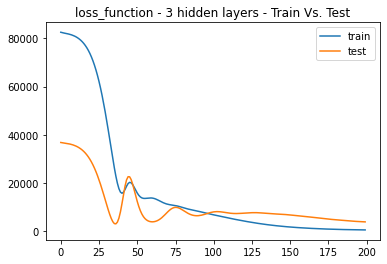

In [ ]:
# Plot train vs test for shallow net
plt.plot(model_1.history["loss"])
plt.plot(model_1.history["val_loss"])
plt.title("loss_function - 3 hidden layers - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

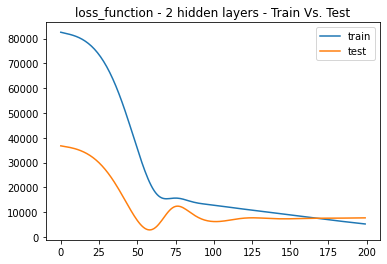

In [ ]:
# Plot train vs test for shallow net
plt.plot(model_2.history["loss"])
plt.plot(model_2.history["val_loss"])
plt.title("loss_function - 2 hidden layers - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

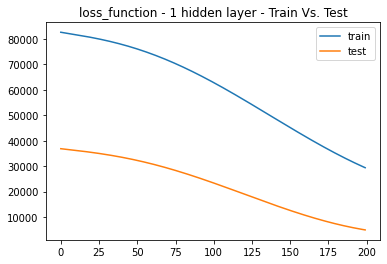

In [ ]:
# Plot train vs test for shallow net
plt.plot(model_3.history["loss"])
plt.plot(model_3.history["val_loss"])
plt.title("loss_function - 1 hidden layer - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

In [ ]:
'''The three hidden layer neural network looked like it did the best.  We have calculated the MSE and the Rsquared 
and at least from the Rsquared, it appears we have good concordance '''

y_pred = nn1.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'Rsquared = {r2_score(y_test, y_pred)}')

MSE = 5348.485964828529
Rsquared = 0.7884195011917787


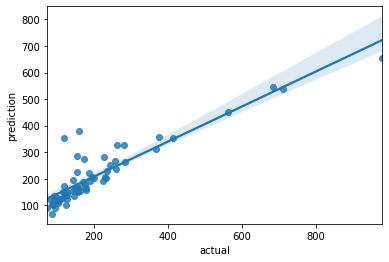

In [ ]:
'''to see the concordance more visually we have created a scatter plot of actual vs predicted 
with a best fit line included'''

X_compare=X_test.copy()
X_compare['prediction']=y_pred
X_compare['actual']=y_test
# X_compare.hvplot.scatter(x='prediction', y='actual', 
#                   legend='top', height=600, width=600)

sns.regplot(X_compare['actual'],X_compare['prediction'])

# Bayesian Gausian mixture cluster model

In [ ]:
'''using kmeans we are getting a crude approximation as to the number of clusters present in the data. and it appears to be about 4'''

from sklearn.cluster import KMeans
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(cluster_scaled)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
alt.Chart(df_elbow).mark_line().encode(x="k", y="inertia").properties(
    width=1000,
    height=500).interactive()

alt.Chart(...)

In [ ]:
'''We have chosen to use a bayesian gaussian clustering, since it gives data on not only the cluster identity, 
but the probability that the element is in a given cluster.'''

from sklearn.mixture import BayesianGaussianMixture
bg=BayesianGaussianMixture(
        n_components=3, 
    covariance_type='tied',
    max_iter=1000,
    init_params='random',
        random_state=0).fit(cluster_train)
cluster_train['cluster']=bg.predict(cluster_train)
cluster_train['cluster'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2    17
0    16
1    15
Name: cluster, dtype: int64

In [ ]:
fig = px.scatter_3d(
    cluster_train,
    x="median_sale_ppsf",
    y="inventory",
    z="average_sale_to_list_ratio",
    color="cluster",
    symbol="cluster",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [ ]:
predictions=bg.predict(cluster_test)
cluster_test['cluster']=predictions
fig = px.scatter_3d(
    cluster_test,
    x="median_sale_ppsf",
    y="inventory",
    z="average_sale_to_list_ratio",
    color="cluster",
    symbol="cluster",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
predictions=bg.predict(cluster_scaled)
probability=bg.predict_proba(cluster_scaled)
score=bg.score_samples(cluster_scaled)
cluster_scaled['cluster']=predictions
cluster_scaled['log likelihood']=score
for x in range(3):
    prob=[]
    for y in range(len(probability)):
        prob.append(probability[y][x])
    cluster_scaled[f'cluster {x} probability']=prob
cluster_scaled.head()


,total_homes_sold,total_homes_sold_yoy,average_homes_sold,average_homes_sold_yoy,total_homes_sold_with_price_drops,total_homes_sold_with_price_drops_yoy,average_homes_sold_with_price_drops,average_homes_sold_with_price_drops_yoy,percent_homes_sold_with_price_drops,percent_homes_sold_with_price_drops_yoy,median_sale_price,median_sale_price_yoy,median_sale_ppsf,median_sale_ppsf_yoy,median_days_to_close,median_days_to_close_yoy,price_drops,price_drops_yoy,percent_active_listings_with_price_drops,percent_active_listings_with_price_drops_yoy,pending_sales,pending_sales_yoy,median_pending_sqft,median_pending_sqft_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,percent_off_market_in_two_weeks,percent_off_market_in_two_weeks_yoy,total_new_listings,total_new_listings_yoy,average_new_listings,average_new_listings_yoy,median_new_listing_price,median_new_listing_price_yoy,median_new_listing_ppsf,median_new_listing_ppsf_yoy,inventory,inventory_yoy,total_active_listings,total_active_listings_yoy,active_listings,active_listings_yoy,age_of_inventory,age_of_inventory_yoy,homes_delisted,homes_delisted_yoy,percent_active_listings_delisted,percent_active_listings_delisted_yoy,median_active_list_price,median_active_list_price_yoy,median_active_list_ppsf,median_active_list_ppsf_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_days_on_market,median_days_on_market_yoy,pending_sales_to_sales_ratio,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,Lat,Lon,pop,density,cluster,log likelihood,cluster 0 probability,cluster 1 probability,cluster 2 probability
region_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Jamestown, NY",0.006255,0.283906,0.006257,0.305134,0.006289,0.018209,0.005298,0.018375,0.416744,0.629189,0.013471,0.525127,0.017151,0.395236,0.917230,0.383202,0.007079,0.033813,0.360311,0.705598,0.008396,0.268085,0.350757,0.616316,0.007651,0.355685,0.687865,0.679476,0.008867,0.228661,0.008621,0.223535,0.038769,0.649425,0.011710,0.262030,0.005867,0.099396,0.006099,0.064715,0.006079,0.062949,0.265347,0.246269,0.005459,0.454545,0.425484,0.632777,0.024976,0.587124,0.016574,0.472523,0.299393,0.509352,0.881020,0.795949,0.520480,0.550416,0.270981,0.410860,0.019509,0.025457,0.710201,0.891265,0.001518,0.099302,1,-13977.467969,1.146289e-67,9.994969e-01,5.031356e-04
"New York, NY",0.353533,0.149805,0.353539,0.159708,0.296260,0.007618,0.295364,0.010284,0.335654,0.523872,0.306438,0.335538,0.257498,0.320796,0.793919,0.328084,1.000000,0.071726,0.279553,0.650136,0.327425,0.267258,0.364829,0.540758,0.078806,0.321995,0.139834,0.455066,0.857131,0.936245,0.857095,0.936243,0.431936,0.708660,0.337432,0.348527,1.000000,0.497519,1.000000,0.479841,1.000000,0.479251,0.384158,0.158849,0.774017,0.278450,0.377471,0.236503,0.432453,0.295867,0.365313,0.642892,0.572464,0.552908,0.646837,0.510128,0.392491,0.587099,1.000000,1.000000,0.608020,0.020071,0.649114,0.997477,1.000000,1.000000,1,124.708250,1.000102e-50,1.000000e+00,2.665719e-51
"Gloversville, NY",0.003225,0.751055,0.003129,0.730660,0.005627,0.035083,0.005298,0.042553,0.726438,0.565382,0.000000,0.000000,0.023013,0.000000,0.701014,0.078740,0.005792,0.033813,0.541359,0.648593,0.004198,0.419149,0.248545,0.429403,0.003060,0.602041,0.623255,0.573060,0.004392,0.570500,0.004310,0.603545,0.057669,0.454519,0.035477,0.187425,0.003272,0.155884,0.003248,0.129995,0.003228,0.128428,0.311881,0.171642,0.002183,0.272727,0.409810,0.558557,0.040672,0.490069,0.027374,0.553098,0.172555,0.142852,0.918791,1.000000,0.422434,0.391263,0.286511,0.083112,0.003974,0.010753,0.751628,0.989046,0.000828,0.086901,1,124.725082,1.950566e-50,1.000000e+00,1.694373e-51
"Syracuse, NY",0.044277,0.161206,0.044192,0.169966,0.026481,0.005651,0.026490,0.008367,0.140343,0.503330,0.047070,0.473886,0.053991,0.456011,0.864865,0.535433,0.037323,0.024052,0.372579,0.586218,0.054104,0.237797,0.327902,0.441870,0.064269,0.

In [ ]:
cluster['cluster']=cluster_scaled['cluster']
cluster['log likelihood']=cluster_scaled['log likelihood']
for x in range(3):
    cluster[f'cluster {x} probability']=cluster_scaled[f'cluster {x} probability']
c0_df=cluster.loc[cluster['cluster']==0]
c1_df=cluster.loc[cluster['cluster']==1]
c2_df=cluster.loc[cluster['cluster']==2]

In [ ]:
'''To quantitate which cluster would have the best investment profile, are ranking how 
each cluster sits within each feature.  First we have found the mean for each feature 
for each cluster, as well as the standard deviation.  We then assigned each feature a as being
a positive for the market (ie, sale to list ratio), a negative (eg, longer days on market),
or neutral (ie, absolute number of buildings on market).  Going through each feature
we assign a value of 1 it it has the largest value for a positive feature, -1 for a negative feature, 
and zero for a neutral feature.  We have then summed all these values.  this annalysis shows
that cluster 1 has the best investment profile, while cluster 3 has the worst profile.'''

features=c2_df.columns.tolist()
header=features[0:-9]
w={}
w['cluster']=['c1a','c2a','c3a','c1s','c2s','c3s']
eval=pd.DataFrame(w)
for feature in header:
    z=[]
    z.append(c0_df[feature].mean())
    z.append(c1_df[feature].mean())
    z.append(c2_df[feature].mean())
    z.append(c0_df[feature].std())
    z.append(c1_df[feature].std())
    z.append(c2_df[feature].std())    
    eval[feature]=z
eval

,cluster,total_homes_sold,total_homes_sold_yoy,average_homes_sold,average_homes_sold_yoy,total_homes_sold_with_price_drops,total_homes_sold_with_price_drops_yoy,average_homes_sold_with_price_drops,average_homes_sold_with_price_drops_yoy,percent_homes_sold_with_price_drops,percent_homes_sold_with_price_drops_yoy,median_sale_price,median_sale_price_yoy,median_sale_ppsf,median_sale_ppsf_yoy,median_days_to_close,median_days_to_close_yoy,price_drops,price_drops_yoy,percent_active_listings_with_price_drops,percent_active_listings_with_price_drops_yoy,pending_sales,pending_sales_yoy,median_pending_sqft,median_pending_sqft_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,percent_off_market_in_two_weeks,percent_off_market_in_two_weeks_yoy,total_new_listings,total_new_listings_yoy,average_new_listings,average_new_listings_yoy,median_new_listing_price,median_new_listing_price_yoy,median_new_listing_ppsf,median_new_listing_ppsf_yoy,inventory,inventory_yoy,total_active_listings,total_active_listings_yoy,active_listings,active_listings_yoy,age_of_inventory,age_of_inventory_yoy,homes_delisted,homes_delisted_yoy,percent_active_listings_delisted,percent_active_listings_delisted_yoy,median_active_list_price,median_active_list_price_yoy,median_active_list_ppsf,median_active_list_ppsf_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_days_on_market,median_days_on_market_yoy,pending_sales_to_sales_ratio,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy
0,c1a,1664.236842,0.028311,415.736842,0.031997,445.763158,-0.177086,111.078947,-0.194193,0.242675,-0.068319,341822.878947,0.135910,193.424651,0.115137,35.355263,1.431579,189.263158,-0.344303,0.053075,-0.005464,368.368421,0.284651,1749.023684,0.035735,212.526316,0.943021,0.573653,0.165897,1833.552632,-0.003210,458.026316,-0.001143,351872.623684,0.114287,201.746290,0.118865,3055.526316,-0.365635,14315.500000,-0.315899,3578.394737,-0.315982,51.152632,-6.315789,91.868421,-0.053521,0.019410,0.005498,396433.126316,0.091887,207.175664,0.094690,0.987670,0.005550,27.568421,-5.892105,1.006392,0.222860,10.001128,-3.905179,530.842105,0.151740
1,c2a,695.620690,0.162446,173.586207,0.163659,178.413793,1.231979,44.241379,1.245728,0.282123,-0.023177,429868.744828,0.063974,254.610617,0.056176,31.668966,1.313793,112.655172,0.140741,0.048935,-0.003175,141.034483,0.231996,1704.386207,0.053920,59.310345,1.122297,0.466455,0.144825,978.241379,0.012196,244.172414,0.009991,452774.700000,0.113735,270.050605,0.095515,2399.344828,-0.338518,10517.689655,-0.299847,2628.965517,-0.300054,51.910345,-9.693103,55.206897,0.232157,0.021545,0.008330,494910.951724,0.107107,275.976789,0.103945,0.984345,0.003944,44.241379,2.741379,0.836841,0.057522,11.191256,-6.749158,256.413793,1.394994
2,c3a,882.137931,0.075149,220.103448,0.082377,239.413793,-0.052130,59.551724,0.008796,0.268496,-0.047704,324712.934483,0.113741,193.455016,0.091257,25.900000,0.068966,94.517241,-0.332722,0.040597,-0.006871,166.068966,0.215165,1653.496552,0.010971,74.655172,0.579649,0.419376,0.076733,984.068966,-0.008306,245.586207,-0.008496,333625.044828,0.113768,201.316528,0.119533,2575.241379,-0.277150,11398.275862,-0.240521,2849.241379,-0.240151,61.841379,-4.379310,56.068966,0.101208,0.016733,0.004054,355171.682759,0.064001,203.279331,0.075739,0.979722,0.005186,51.344828,1.244828,0.849076,0.075898,13.424976,-4.916900,337.103448,0.224847
3,c1s,2548.231877,0.195479,637.041417,0.207664,722.908219,0.250537,180.757772,0.237642,0.079955,0.074065,219065.947518,0.111177,118.899235,0.105280,11.170151,4.848076,339.007110,0.264012,0.013976,0.013190,535.915101,0.267759,175.716381,0.067401,312.750201,0.576455,0.118176,0.075733,2851.891394,0.147494,712.925889,0.147449,235641.294984,0.075759,127.216669,0.083813,5392.143272,0.142806,24722.587376,0.127516,6180.607543,0.127752,22.575252,15.162766,193.926173,0.338658,0.006548,0.005551,267121.322697,0.072071,135.990

In [ ]:
wins={
'total_homes_sold':0,
 'total_homes_sold_yoy':1,
 'average_homes_sold':0,
 'average_homes_sold_yoy':1,
 'total_homes_sold_with_price_drops':0,
 'total_homes_sold_with_price_drops_yoy':-1,
 'average_homes_sold_with_price_drops':-1,
 'average_homes_sold_with_price_drops_yoy':-1,
 'percent_homes_sold_with_price_drops':-1,
 'percent_homes_sold_with_price_drops_yoy':-1,
 'median_sale_price':1,
 'median_sale_price_yoy':1,
 'median_sale_ppsf':1,
 'median_sale_ppsf_yoy':1,
 'median_days_to_close':-1,
 'median_days_to_close_yoy':-1,
 'price_drops':-1,
 'price_drops_yoy':-1,
 'percent_active_listings_with_price_drops':-1,
 'percent_active_listings_with_price_drops_yoy':-1,
 'pending_sales':0,
 'pending_sales_yoy':1,
 'median_pending_sqft':0,
 'median_pending_sqft_yoy':1,
 'off_market_in_two_weeks':1,
 'off_market_in_two_weeks_yoy':1,
 'percent_off_market_in_two_weeks':1,
 'percent_off_market_in_two_weeks_yoy':1,
 'total_new_listings':0,
 'total_new_listings_yoy':0,
 'average_new_listings':0,
 'average_new_listings_yoy':0,
 'median_new_listing_price':1,
 'median_new_listing_price_yoy':1,
 'median_new_listing_ppsf':1,
 'median_new_listing_ppsf_yoy':1,
 'inventory':-1,
 'inventory_yoy':-1,
 'total_active_listings':0,
 'total_active_listings_yoy':-1,
 'active_listings':0,
 'active_listings_yoy':-1,
 'age_of_inventory':-1,
 'age_of_inventory_yoy':-1,
 'homes_delisted':-1,
 'homes_delisted_yoy':-1,
 'percent_active_listings_delisted':-1,
 'percent_active_listings_delisted_yoy':-1,
 'median_active_list_price':1,
 'median_active_list_price_yoy':1,
 'median_active_list_ppsf':1,
 'median_active_list_ppsf_yoy':1,
 'average_sale_to_list_ratio':1,
 'average_sale_to_list_ratio_yoy':1,
 'median_days_on_market':-1,
 'median_days_on_market_yoy':-1,
 'pending_sales_to_sales_ratio':1,
 'pending_sales_to_sales_ratio_yoy':1,
 'months_of_supply':-1,
 'months_of_supply_yoy':-1,
 'average_pending_sales_listing_updates':0,
 'average_pending_sales_listing_updates_yoy':1}

In [ ]:
tally={'cluster 0':[], 'cluster 1':[], 'cluster 2':[],}
for key in wins:
    key1=eval.loc[0,key]
    key2=eval.loc[1,key]
    key3=eval.loc[2,key]
    if key1<key2 and key1<key3:
        tally['cluster 0'].append(-1*wins[key])
    elif key1>key2 and key1>key3:
        tally['cluster 0'].append(1*wins[key])
    else:
        tally['cluster 0'].append(0)
        
    if key2<key1 and key2<key3:
        tally['cluster 1'].append(-1*wins[key])
    elif key2>key1 and key2>key3:
        tally['cluster 1'].append(1*wins[key])
    else:
        tally['cluster 1'].append(0)
        
    if key3<key2 and key3<key1:
        tally['cluster 2'].append(-1*wins[key])
    elif key3>key2 and key3>key1:
        tally['cluster 2'].append(1*wins[key])
    else:
        tally['cluster 2'].append(0)
        
sums=pd.DataFrame(tally)
sums['features']=header
sums.set_index('features', inplace=True)

In [ ]:
sums.sum()

cluster 0    12
cluster 1     0
cluster 2   -12
dtype: int64

In [ ]:
sums

,cluster 0,cluster 1,cluster 2
features,,,
total_homes_sold,0,0,0
total_homes_sold_yoy,-1,1,0
average_homes_sold,0,0,0
average_homes_sold_yoy,-1,1,0
total_homes_sold_with_price_drops,0,0,0
...,...,...,...
pending_sales_to_sales_ratio_yoy,1,-1,0
months_of_supply,1,0,-1
months_of_supply_yoy,-1,1,0


In [ ]:
lst=eval['median_sale_ppsf_yoy'].to_list()
ave_dict={'cluster':['0','1','2'], 'median_sale_ppsf_yoy':lst[0:3], 'error':lst[3:]}
ret=pd.DataFrame(ave_dict)
ret['err_max']=ret['median_sale_ppsf_yoy']+ret['error']
ret['err_min']=ret['median_sale_ppsf_yoy']-ret['error']
ret


alt.Chart(ret).mark_bar(size=50).encode(
    x='cluster',
    y=alt.Y('median_sale_ppsf_yoy', title='YoY median sale ppsf change'),
).properties(
    width=500,
    height=500
).interactive()




alt.Chart(...)

In [ ]:
c0_df.sort_values(by=['median_sale_ppsf']).sort_values(by=['median_sale_ppsf'])

,total_homes_sold,total_homes_sold_yoy,average_homes_sold,average_homes_sold_yoy,total_homes_sold_with_price_drops,total_homes_sold_with_price_drops_yoy,average_homes_sold_with_price_drops,average_homes_sold_with_price_drops_yoy,percent_homes_sold_with_price_drops,percent_homes_sold_with_price_drops_yoy,median_sale_price,median_sale_price_yoy,median_sale_ppsf,median_sale_ppsf_yoy,median_days_to_close,median_days_to_close_yoy,price_drops,price_drops_yoy,percent_active_listings_with_price_drops,percent_active_listings_with_price_drops_yoy,pending_sales,pending_sales_yoy,median_pending_sqft,median_pending_sqft_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,percent_off_market_in_two_weeks,percent_off_market_in_two_weeks_yoy,total_new_listings,total_new_listings_yoy,average_new_listings,average_new_listings_yoy,median_new_listing_price,median_new_listing_price_yoy,median_new_listing_ppsf,median_new_listing_ppsf_yoy,inventory,inventory_yoy,total_active_listings,total_active_listings_yoy,active_listings,active_listings_yoy,age_of_inventory,age_of_inventory_yoy,homes_delisted,homes_delisted_yoy,percent_active_listings_delisted,percent_active_listings_delisted_yoy,median_active_list_price,median_active_list_price_yoy,median_active_list_ppsf,median_active_list_ppsf_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_days_on_market,median_days_on_market_yoy,pending_sales_to_sales_ratio,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,Lat,Lon,pop,density,cluster,log likelihood,cluster 0 probability,cluster 1 probability,cluster 2 probability
region_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pontiac, IL",36.0,0.384615,9.0,0.500000,12.0,0.000000,3.0,0.000000,0.332576,-0.069210,114500.0,0.296532,67.450997,0.039753,46.3,21.1,5.0,-0.166667,0.050280,0.009933,5.0,0.250000,1599.8,-0.080152,3.0,0.500000,0.634524,0.197024,29.0,-0.256410,7.0,-0.222222,120100.0,0.042761,81.369772,0.133653,106.0,-0.329114,459.0,-0.315946,114.0,-0.317365,99.7,9.5,1.0,0.000000,0.010821,0.000412,108812.5,0.111182,67.699910,0.009257,0.934857,-0.016565,41.6,-8.4,0.624747,-0.168407,13.410101,-16.915792,9.0,-0.307692,40.8881,-88.6414,12196.0,563.0,0,124.549259,1.0,1.294065e-50,3.165594e-48
"Olean, NY",56.0,0.098039,14.0,0.166667,13.0,-0.350000,3.0,-0.400000,0.231214,-0.163512,144000.0,0.471828,79.699529,0.374634,53.2,-7.1,8.0,-0.500000,0.038318,-0.009756,12.0,0.333333,1576.7,0.106767,6.0,1.000000,0.556410,0.214608,77.0,0.040541,19.0,0.055556,91425.0,-0.124910,75.767545,0.072519,204.0,-0.374233,884.0,-0.356154,221.0,-0.355685,111.5,34.2,2.0,-0.500000,0.010146,-0.001501,130375.0,0.069086,90.320691,0.115727,0.961274,0.039311,62.2,-13.1,0.857776,0.139827,16.053221,-11.221342,24.0,0.333333,42.0819,-78.4321,21178.0,897.0,0,-164952.085814,1.0,1.079708e-218,2.799289e-201
"Dixon, IL",27.0,-0.250000,6.0,-0.333333,7.0,-0.300000,1.0,-0.500000,0.250000,-0.029221,118541.6,-0.166667,86.072962,0.113417,42.7,-3.3,6.0,0.000000,0.066054,0.020058,7.0,0.750000,1464.1,0.016172,3.0,0.500000,0.402146,-0.097854,33.0,-0.312500,8.0,-0.333333,128687.5,0.012988,80.188211,0.012248,92.0,-0.333333,407.0,-0.303082,101.0,-0.308219,70.5,11.5,1.0,-0.500000,0.013052,-0.000750,126962.5,-0.025614,78.501916,-0.026364,0.946825,0.007002,18.3,-14.2,1.333333,0.826840,18.500000,1.357143,9.0,0.125000,41.8439,-89.4788,16288.0,780.0,0,-130192.161611,1.0,7.841874e-304,5.050403e-274
"Amsterdam, NY",28.0,-0.317073,7.0,-0.300000,6.0,-0.454545,1.0,-0.500000,0.194712,-0.045765,122186.2,0.158337,91.988953,0.497124,52.1,-6.4,6.0,-0.400000,0.040125,-0.017004,8.0,1.000000,1678.5,0.060865,4.0,3.000000,0.565584,0.223918,57.0,0.075472,14.0,0.076923,130325.0,0.193726,83.509844,0.520186,135.0,-0.205882,600.0,-0.164345,150.0,-0.162011,70.7,9.0,2.0,0.000000,0.018340,0.004464,121581.1,-0.025695,66.994871,-0.035580,0.980113,0.025305,82.2,39.7,1.582532,1.087492,29.313301,11.014789,1

In [ ]:
c1_df.sort_values(by=['median_sale_ppsf']).sort_values(by=['median_sale_ppsf'])

,total_homes_sold,total_homes_sold_yoy,average_homes_sold,average_homes_sold_yoy,total_homes_sold_with_price_drops,total_homes_sold_with_price_drops_yoy,average_homes_sold_with_price_drops,average_homes_sold_with_price_drops_yoy,percent_homes_sold_with_price_drops,percent_homes_sold_with_price_drops_yoy,median_sale_price,median_sale_price_yoy,median_sale_ppsf,median_sale_ppsf_yoy,median_days_to_close,median_days_to_close_yoy,price_drops,price_drops_yoy,percent_active_listings_with_price_drops,percent_active_listings_with_price_drops_yoy,pending_sales,pending_sales_yoy,median_pending_sqft,median_pending_sqft_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,percent_off_market_in_two_weeks,percent_off_market_in_two_weeks_yoy,total_new_listings,total_new_listings_yoy,average_new_listings,average_new_listings_yoy,median_new_listing_price,median_new_listing_price_yoy,median_new_listing_ppsf,median_new_listing_ppsf_yoy,inventory,inventory_yoy,total_active_listings,total_active_listings_yoy,active_listings,active_listings_yoy,age_of_inventory,age_of_inventory_yoy,homes_delisted,homes_delisted_yoy,percent_active_listings_delisted,percent_active_listings_delisted_yoy,median_active_list_price,median_active_list_price_yoy,median_active_list_ppsf,median_active_list_ppsf_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_days_on_market,median_days_on_market_yoy,pending_sales_to_sales_ratio,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,Lat,Lon,pop,density,cluster,log likelihood,cluster 0 probability,cluster 1 probability,cluster 2 probability
region_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Jamestown, NY",84.0,-0.142857,21.0,-0.125000,23.0,-0.080000,5.0,-0.166667,0.275260,0.023458,116737.5,0.149642,72.566547,0.044978,54.3,-2.4,14.0,-0.333333,0.049308,0.009563,20.0,-0.047619,1661.7,0.111356,11.0,0.571429,0.560208,0.215848,131.0,-0.090278,32.0,-0.111111,142525.0,0.139630,86.381943,0.139314,263.0,-0.483301,1179.0,-0.455427,294.0,-0.456562,49.5,-16.8,6.0,0.500000,0.020303,0.012442,134675.0,0.127813,82.383557,0.081700,0.952246,0.001782,98.0,42.8,1.015183,0.146447,14.173419,-8.227478,59.0,0.512821,42.0975,-79.2366,41236.0,1278.0,1,-13977.467969,1.146289e-67,0.999497,5.031356e-04
"Gloversville, NY",53.0,0.472222,13.0,0.444444,21.0,0.500000,5.0,0.666667,0.380987,-0.024496,97583.0,-0.237633,77.974513,-0.250516,41.5,-14.0,12.0,-0.333333,0.066059,0.005421,11.0,0.375000,1565.1,0.005202,5.0,1.500000,0.511364,0.136364,77.0,0.241935,19.0,0.266667,167437.5,0.035482,107.924186,0.100811,171.0,-0.412371,755.0,-0.382666,188.0,-0.383607,54.2,-23.8,3.0,0.000000,0.019886,0.010133,156512.5,0.096698,92.411027,0.104857,0.938598,-0.026252,102.0,70.0,0.836765,-0.186684,14.751681,-20.134683,16.0,0.000000,43.0491,-74.3465,27893.0,1143.0,1,124.725082,1.950566e-50,1.000000,1.694373e-51
"Rockford, IL",297.0,0.108209,74.0,0.104478,80.0,0.194030,20.0,0.250000,0.261816,0.007203,150225.0,0.064953,89.770131,0.052933,40.0,2.7,27.0,-0.526316,0.066605,-0.009500,68.0,0.360000,1572.7,0.006464,41.0,0.464286,0.606039,0.044593,269.0,-0.213450,67.0,-0.211765,151500.0,0.064372,87.896063,0.031241,331.0,-0.515373,1659.0,-0.450662,414.0,-0.451656,45.2,-1.0,8.0,-0.428571,0.019320,0.000854,164325.0,0.118618,88.220365,0.048709,0.985140,0.016194,10.1,-5.0,0.998992,0.228774,5.961634,-5.580588,81.0,0.094595,42.2598,-89.0641,285562.0,882.0,1,-15329.249240,3.682762e-57,1.000000,2.119689e-84
"Brownwood, TX",44.0,0.222222,11.0,0.222222,13.0,0.300000,3.0,0.500000,0.270833,-0.028667,135862.5,-0.049913,90.905172,0.119690,24.8,0.8,6.0,-0.454545,0.044420,-0.011300,6.0,0.000000,1662.5,0.039842,3.0,2.000000,0.365530,0.087753,41.0,-0.267857,10.0,-0.285714,181562.5,0.137431,103.897908,0.125119,122.0,-0.351064,538.0,-0.321564,134.0,-0.323232,64.3,-2.7,2.0,1.000000,0.014943,0.007340,171812.5,0.111695,98.402127,0.082110,0.987315,0.018312,50.5,7.5,0.64

In [ ]:
c2_df.sort_values(by=['median_sale_ppsf'])

,total_homes_sold,total_homes_sold_yoy,average_homes_sold,average_homes_sold_yoy,total_homes_sold_with_price_drops,total_homes_sold_with_price_drops_yoy,average_homes_sold_with_price_drops,average_homes_sold_with_price_drops_yoy,percent_homes_sold_with_price_drops,percent_homes_sold_with_price_drops_yoy,median_sale_price,median_sale_price_yoy,median_sale_ppsf,median_sale_ppsf_yoy,median_days_to_close,median_days_to_close_yoy,price_drops,price_drops_yoy,percent_active_listings_with_price_drops,percent_active_listings_with_price_drops_yoy,pending_sales,pending_sales_yoy,median_pending_sqft,median_pending_sqft_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,percent_off_market_in_two_weeks,percent_off_market_in_two_weeks_yoy,total_new_listings,total_new_listings_yoy,average_new_listings,average_new_listings_yoy,median_new_listing_price,median_new_listing_price_yoy,median_new_listing_ppsf,median_new_listing_ppsf_yoy,inventory,inventory_yoy,total_active_listings,total_active_listings_yoy,active_listings,active_listings_yoy,age_of_inventory,age_of_inventory_yoy,homes_delisted,homes_delisted_yoy,percent_active_listings_delisted,percent_active_listings_delisted_yoy,median_active_list_price,median_active_list_price_yoy,median_active_list_ppsf,median_active_list_ppsf_yoy,average_sale_to_list_ratio,average_sale_to_list_ratio_yoy,median_days_on_market,median_days_on_market_yoy,pending_sales_to_sales_ratio,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,Lat,Lon,pop,density,cluster,log likelihood,cluster 0 probability,cluster 1 probability,cluster 2 probability
region_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Freeport, IL",30.0,0.578947,7.0,0.750000,10.0,0.666667,2.0,1.000000,0.337798,0.004464,120662.5,0.011951,56.743435,-0.109599,30.6,-12.9,5.0,0.000000,0.066886,0.009947,9.0,2.000000,1491.5,-0.203939,3.0,2.000000,0.437500,-0.291667,30.0,-0.062500,7.0,-0.125000,131150.0,0.130116,82.164616,0.421596,66.0,-0.274725,316.0,-0.183463,79.0,-0.177083,49.3,-22.4,1.0,-0.500000,0.012143,-0.007245,99925.0,0.097926,68.046122,0.233296,0.920031,-0.029960,66.8,-33.9,1.230159,0.646825,10.945933,-12.001984,12.0,1.000000,42.2892,-89.6348,24412.0,799.0,2,124.184960,2.768004e-48,4.998538e-51,1.0
"Auburn, NY",29.0,-0.516667,7.0,-0.533333,7.0,-0.650000,1.0,-0.800000,0.204167,-0.117105,130000.0,0.025823,85.282162,0.016387,34.8,-10.0,10.0,-0.285714,0.051076,0.002418,11.0,-0.083333,1593.1,0.021218,5.0,1.500000,0.416830,0.169987,75.0,0.119403,18.0,0.125000,194300.0,0.326959,110.728224,0.201745,187.0,-0.336879,821.0,-0.311819,205.0,-0.312081,56.6,-7.5,2.0,1.000000,0.010928,0.005401,172200.0,0.083786,100.556431,0.065504,0.963368,0.008985,70.7,19.7,1.764583,0.886404,30.456250,7.958041,30.0,0.304348,42.9338,-76.5685,31126.0,1236.0,2,-103573.758802,0.000000e+00,7.905050e-323,1.0
"El Paso, TX",876.0,0.146597,219.0,0.146597,121.0,-0.335165,30.0,-0.333333,0.139821,-0.104799,177437.5,0.082014,103.531386,0.072081,35.8,7.0,34.0,-0.617978,0.015970,-0.013545,177.0,0.246479,1749.2,0.044798,103.0,0.872727,0.584991,0.196442,931.0,0.015267,232.0,0.013100,185620.6,0.060025,105.701269,0.069710,1891.0,-0.326807,8596.0,-0.294079,2149.0,-0.294021,70.2,8.5,28.0,-0.428571,0.013093,-0.003256,194925.0,0.067300,111.501873,0.094389,0.991889,0.006765,37.2,-4.4,0.818672,0.056056,9.918670,-6.463059,234.0,0.158416,31.8479,-106.4309,845674.0,1025.0,2,125.612171,3.734309e-46,5.349842e-51,1.0
"Syracuse, NY",473.0,-0.304412,118.0,-0.305882,84.0,-0.511628,21.0,-0.511628,0.180900,-0.071130,164512.5,0.111853,106.553222,0.090416,51.2,3.4,61.0,-0.460177,0.050443,0.000889,118.0,-0.132353,1640.1,0.012282,85.0,1.361111,0.724675,0.455254,770.0,-0.083333,192.0,-0.085714,170712.5,0.146298,108.861177,0.146201,1077.0,-0.490298,4883.0,-0.468141,1220.0,-0.468410,42.2,-7.3,15.0,-0.250000,0.012458,0.003655,177425.0,0.109600,105.713202,0.108403,1.002117,0.020436,26.3,-6.0,1.018

In [ ]:


alt.Chart(cluster).mark_circle().encode(
    alt.X('median_sale_ppsf',
        scale=alt.Scale(zero=False)),
    y='median_sale_ppsf_yoy',
    color=alt.Color('cluster', scale=alt.Scale(scheme='dark2'))
).properties(
    width=500,
    height=500
).interactive()

alt.Chart(...)

In [ ]:
alt.Chart(c0_df).mark_circle().encode(
    alt.X('median_sale_ppsf',
        scale=alt.Scale(zero=False)),
    y='median_sale_ppsf_yoy',
    color=alt.Color('cluster', scale=alt.Scale(scheme='tableau10'))
).properties(
    width=500,
    height=500
).interactive()

alt.Chart(...)

In [ ]:
alt.Chart(c1_df).mark_circle().encode(
    alt.X('median_sale_ppsf',
        scale=alt.Scale(zero=False)),
    y='median_sale_ppsf_yoy',
    color=alt.Color('cluster', scale=alt.Scale(scheme='tableau10'))
).properties(
    width=500,
    height=500
).interactive()

alt.Chart(...)

In [ ]:
alt.Chart(c2_df).mark_circle().encode(
    alt.X('median_sale_ppsf',
        scale=alt.Scale(zero=False)),
    y='median_sale_ppsf_yoy',
    color=alt.Color('cluster', scale=alt.Scale(scheme='tableau10'))
).properties(
    width=500,
    height=500
).interactive()

alt.Chart(...)

In [ ]:
'''You need to have your own API key for MapBox upladed into google colab to use this graph'''

from dotenv import load_dotenv
load_dotenv()
mapbox_token=os.environ['MAPBOX_TOKEN']
px.set_mapbox_access_token(mapbox_token)

map=px.scatter_mapbox(
        cluster,
        lat="Lat",
        lon="Lon",
        color='cluster',
        hover_name=cluster.index,
        zoom=3,
        color_continuous_scale=px.colors.sequential.Blackbody,
        title=f'Geographic d',
        width=850, height=650
    )
map